In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.text import *
from fastai.vision import *
from fastai.utils.mem import *
from fastai.basic_train import Learner, LearnerCallback
from fastai.tabular import *
import scipy.signal as s

In [3]:
path = Path("data/LFP_Prediction")

In [4]:
df = pd.read_csv(path/"model_LFP_and_FR.csv")

In [5]:
#df.to_csv(path/"LFP_and_y", index = False)

In [6]:
#df = pd.read_csv(path/"LFP_and_y")

In [7]:
series = df["LFP"]

## Filtering

In [8]:
b_fit, a_fit = s.butter(2, [30, 80], 'bandpass', fs = 1000)

In [9]:
x = s.filtfilt(b_fit, a_fit, list(series))

In [10]:
mean = np.mean(x)

In [11]:
std = np.std(x)

In [12]:
x = (x - mean) / std

Original

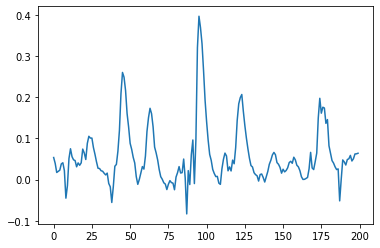

In [13]:
plt.plot(series[:200])
plt.show()

Filtered

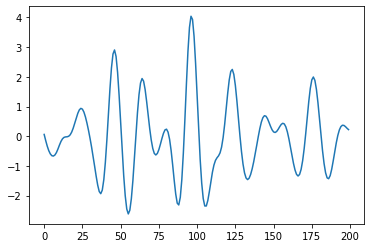

In [14]:
plt.plot(x[:200])
plt.show()

## Finding Spikes and Making Y Values

In [15]:
maxInd = s.argrelextrema(x, np.greater)[0]

In [16]:
minInd = s.argrelextrema(x, np.less)[0]

In [17]:
thresh = 1.536

In [18]:
spikes = []
spike = []
for i in range(0, len(maxInd)):
    if x[maxInd[i]] > thresh:
        spike.append(maxInd[i])
    else:
        if len(spike) >= 3:
            spikes.append(np.array(spike))
        spike = []   

In [19]:
spike_lens = []
for spike in spikes:
    spike_lens.append(spike[-1] - spike[0])

In [20]:
a = np.zeros(len(x))

In [21]:
a[np.concatenate(np.array(spikes))] = 1

In [22]:
b = np.full((len(series)), thresh)

In [23]:
def plot(start, stop, y = None, preds = None):
    plt.plot(a[start:stop])
    plt.plot(x[start:stop])
    plt.plot(b[start:stop])
    if y is not None:
        plt.plot(y[start:stop])
    if preds is not None:
        plt.plot(preds[start:stop])
    plt.show()

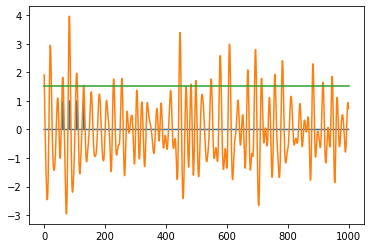

In [24]:
plot(5000, 6000)

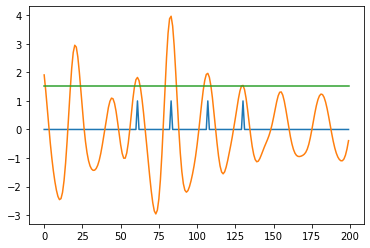

In [25]:
plot(5000, 5200)

In [26]:
y = np.full(len(series), 0)

In [27]:
for spike in spikes:
    y[spike[0]:spike[-1]] = 1

In [28]:
df["y"] = y

In [29]:
#np.save("LFP_Class_Y", y)
#np.save("LFP_Class_Y_ptop", y)

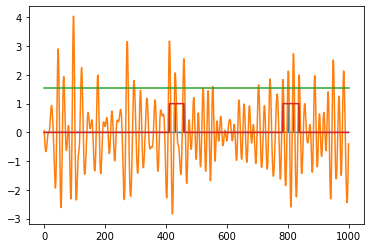

In [30]:
plot(0, 1000, y = y)

## Data

In [9]:
combine = np.stack((df["LFP"], df["Int_FR"], df["PN_FR"], df["y"]), axis = -1)

In [10]:
class TargetTimePoints(ItemList):
    def reconstruct(self, t:Tensor): 
        return t

In [11]:
class TimePointsPlus(ItemBase):
    def __init__(self, timePoints, num_features, seq_len, reconstruct = False, for_pred = False):
        self.obj = (timePoints)
        self.data = torch.Tensor(timePoints)
        if not reconstruct:
            self.data = torch.transpose(self.data, 0, 1)
            if not for_pred:
                self.data = self.data.reshape((num_features, seq_len))
            else:
                self.data = self.data.reshape((1, num_features, seq_len))
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"

In [12]:
class TimePointsPlusList(ItemList):
    _label_cls = CategoryList
    def __init__(self, items, num_back, num_forward, **kwargs):
        self.its = items
        super().__init__(items[:-(num_back + num_forward)], **kwargs)
        self.num_forward = num_forward
        self.num_back = num_back
        self.copy_new.append("num_back")
        self.copy_new.append("num_forward")
        
    def get(self, i):
        return TimePointsPlus(self.its[i : self.num_back + i, :3], 3, num_back)
    
    def reconstruct(self, t:Tensor):
        return TimePointsPlus(t, 3, num_back, reconstruct = True)
    
    def __len__(self):
        return len(self.its) - self.num_back - self.num_forward
    
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    def label_func(self, i):
        #return torch.Tensor(int(1 in self.its[i + self.num_back: i + self.num_back + self.num_forward, 3]))[None]
        val = int(1 in self.its[i + self.num_back: i + self.num_back + self.num_forward, 3])
        obj = "spike"
        if val == 0:
            obj = "noise"
        return val

In [13]:
num_back = 100
num_forward = 10

In [14]:
data = (TimePointsPlusList(combine, num_back, num_forward)
                .split_by_idx(range(500000))
                .label_from_func(lambda x: x)
                .databunch(bs = 512))

In [15]:
data

DataBunch;

Train: LabelList (768781 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (499890 items)
x: TimePointsPlusList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,0,0
Path: .;

Test: None

In [38]:
class MultivariateConvModel(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.convs = nn.Sequential(
            nn.BatchNorm1d(3),
            nn.Conv1d(3, 64, 5, padding = 2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(),
            nn.Conv1d(64, 128, 5, stride = 2, padding = 2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.lins = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(),
            nn.Linear(64, out_size)
        )
        
    def forward(self, x):
        x = self.convs(x)
        x = torch.squeeze(x, dim = 2)
        return self.lins(x)

In [39]:
def isNan(num):
    return num != num

In [40]:
def spike_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 1
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

In [41]:
def noise_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 0
    return (input[mask]==targs[mask]).float().mean()

In [48]:
learn = Learner(data, MultivariateConvModel(num_back, 2), metrics = [error_rate, accuracy, spike_acc, noise_acc], wd = 1e-7)

In [49]:
learn.loss_func.func = torch.nn.modules.loss.CrossEntropyLoss(weight = torch.Tensor([.1, 3]).cuda())

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-03
Min loss divided by 10: 1.74E-02


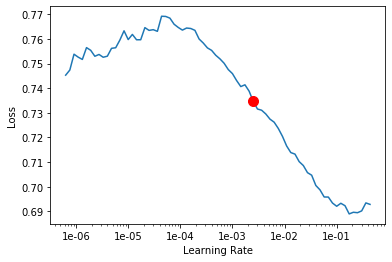

In [51]:
learn.recorder.plot(skip_end = 10, suggestion = True)

In [52]:
lr = 1e-3

In [53]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,error_rate,accuracy,spike_acc,noise_acc,time
0,0.579462,0.698168,0.551297,0.448703,0.368208,0.421571,00:42
1,0.560020,0.685500,0.515743,0.484257,0.370642,0.459635,00:42
2,0.545605,0.605643,0.376157,0.623843,0.329948,0.613478,00:42
3,0.525055,0.608916,0.371018,0.628982,0.331504,0.619293,00:42
4,0.509130,0.607360,0.369707,0.630293,0.334703,0.620328,00:42
5,0.495889,0.625161,0.397745,0.602255,0.342882,0.589245,00:42
6,0.487981,0.588886,0.336614,0.663386,0.321475,0.657299,00:42
7,0.485307,0.586696,0.322131,0.677869,0.314493,0.674048,00:42
8,0.475804,0.592861,0.334776,0.665224,0.321648,0.659510,00:42
9,0.480142,0.589843,0.331273,0.668727,0.319995,0.663477,00:42


In [54]:
learn.save("current_classification_cnn")

In [55]:
learn.summary()

MultivariateConvModel
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          [3, 100]             6          True      
______________________________________________________________________
Conv1d               [64, 100]            1,024      True      
______________________________________________________________________
ReLU                 [64, 100]            0          False     
______________________________________________________________________
BatchNorm1d          [64, 100]            128        True      
______________________________________________________________________
Dropout              [64, 100]            0          False     
______________________________________________________________________
Conv1d               [128, 50]            41,088     True      
______________________________________________________________________
ReLU                 [128, 50]            0          False     
________________________________________

## Results

In [146]:
preds = np.array(list(np.zeros(100)) + list(learn.get_preds(DatasetType.Valid)[1])) * 2

Purple is the time steps that the model classifies as having a spike within the next ten ms

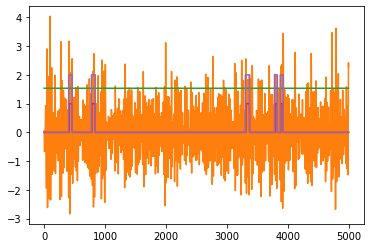

In [141]:
plot(0, 5000, combine[: , 3], preds)

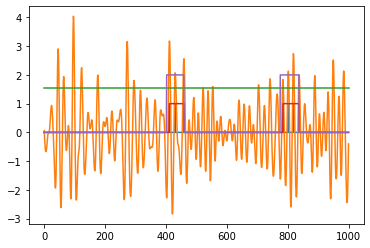

In [137]:
plot(0, 1000, combine[: , 3], preds)

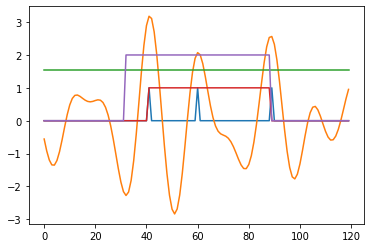

In [139]:
plot(370, 490, combine[: , 3], preds)

## Interpretation

In [147]:
learn.loss_func.func = torch.nn.modules.loss.CrossEntropyLoss(weight = torch.Tensor([.1, 3]).cpu())

In [148]:
interp = ClassificationInterpretation.from_learner(learn)

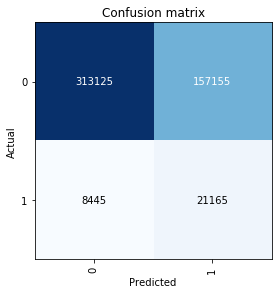

In [149]:
interp.plot_confusion_matrix()

In [153]:
confusion_matrix = interp.confusion_matrix()

Spike accuracy

In [155]:
confusion_matrix[1][1] / confusion_matrix[1].sum()

0.7147922998986829

Noise (non-spike) accuracy

In [158]:
confusion_matrix[0][0] / confusion_matrix[0].sum()

0.6658267415156928

## Explainability

In [159]:
from fastai.callbacks.hooks import *

In [160]:
learn.summary()

MultivariateConvModel
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          [3, 100]             6          True      
______________________________________________________________________
Conv1d               [64, 100]            1,024      True      
______________________________________________________________________
ReLU                 [64, 100]            0          False     
______________________________________________________________________
BatchNorm1d          [64, 100]            128        True      
______________________________________________________________________
Dropout              [64, 100]            0          False     
______________________________________________________________________
Conv1d               [128, 50]            41,088     True      
______________________________________________________________________
ReLU                 [128, 50]            0          False     
________________________________________

In [161]:
m = learn.model.eval()

In [216]:
def hooked_backward(cat, xb):
    with hook_output(m.convs[-3]) as hook_a: 
        with hook_output(m.convs[-3], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [217]:
def show_heatmap(data, item, m):
    y = item[1]
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    hook_a,hook_g = hooked_backward(y, xb)
    acts = hook_a.stored[0].cpu()
    acts_mean = np.array(acts.mean(dim = 0))
    acts_mean = np.repeat(acts_mean, 2)
    disp = np.repeat(acts_mean[None], 100, axis = 0)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.plot(item[0].data[1])
    plt.plot(item[0].data[2])

    # Get second axis
    ax2 = ax.twinx()
    plt.imshow(disp, alpha = 0.6, interpolation='bilinear')

    # Get second axis
    ax3 = ax.twinx()
    plt.plot(item[0].data[0], color = "red")

    plt.show()

In [243]:
def show_grad_heatmap(data, item, m):
    y = item[1]
    xb, _ = data.one_item(item[0])
    xb = xb.cuda()
    hook_a,hook_g = hooked_backward(y, xb)
    acts = hook_a.stored[0].cpu()
    
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1)
    disp = (acts*grad_chan[...,None]).mean(0)
    disp = np.repeat(disp, 2)
    disp = np.repeat(disp[None], 100, axis = 0)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    plt.plot(item[0].data[1])
    plt.plot(item[0].data[2])

    # Get second axis
    ax2 = ax.twinx()
    plt.imshow(disp, alpha = 0.6, interpolation='bilinear')

    # Get second axis
    ax3 = ax.twinx()
    plt.plot(item[0].data[0], color = "red")

    plt.show()

example of spike, non Grad CAM

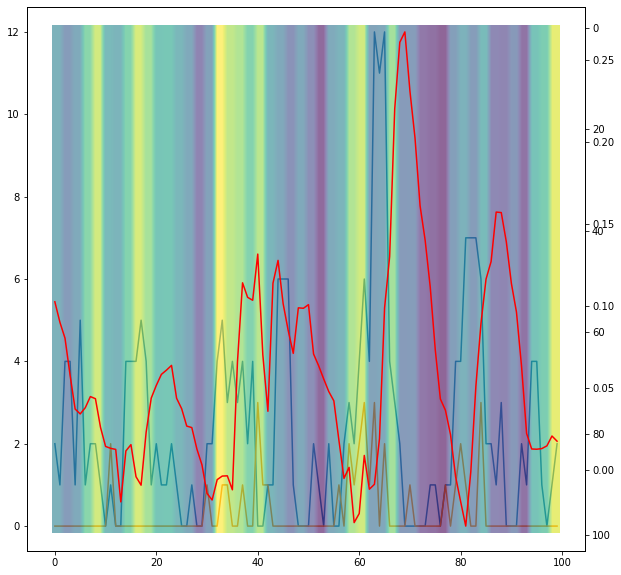

In [245]:
show_heatmap(data, data.valid_ds[342], m)

Same spike with Grad CAM

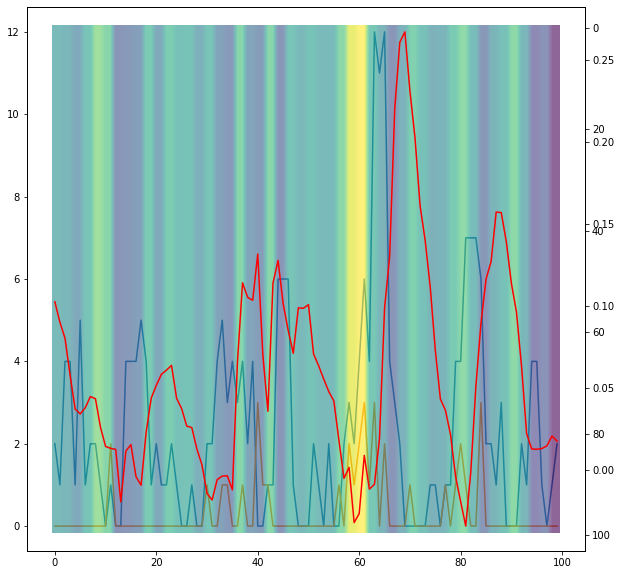

In [246]:
show_grad_heatmap(data, data.valid_ds[342], m)

example of no spike, no Grad CAM

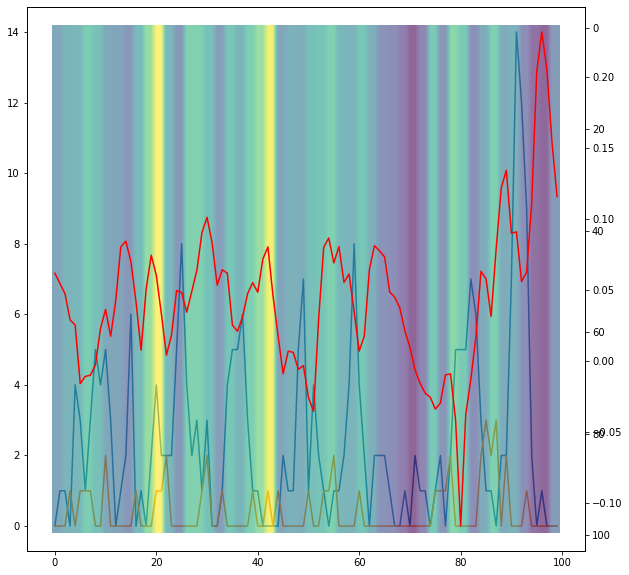

In [224]:
show_heatmap(data, data.valid_ds[3422], m)

Same non-spike with Grad CAM

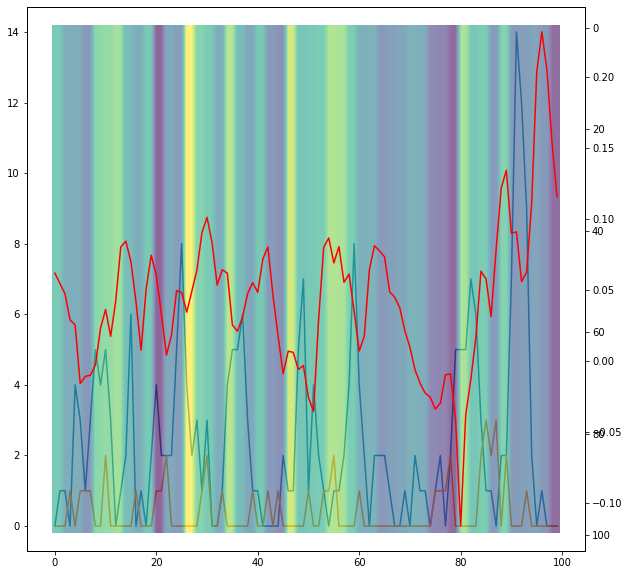

In [247]:
show_grad_heatmap(data, data.valid_ds[3422], m)